In [1]:
from numpy import *   #ones, cumsum, sum, isscalar
from matplotlib.pylab import * 
%matplotlib inline
plotose = True
import pickle

import PS_lib as lb
import PS_storage as st
import PS_tools as tools

from bootstrap_unshr import btset_cd, generateplots, btShInh, btShInhwpos
from data_Fullset import SCxL23 as exppar

# Parameter definitions
# Data is stored here      
data = st.dataStorage() # some default parameters defined.
data.dt = 0.05
data.NMDA = False

# Definition of the model.
lb.h.dt = data.dt
NMDA = data.NMDA
model = lb.loadNeuron("ball-2sticks.hoc",axon=False)

# Adding piece of dendritic branch with spine
model.addDend(name="dendShaft",locus="dendA1",L=4.0,D=1.5,ilocus=1)
model.addSpne(locus="dendShaft",ilocus=0.5,L=1.0,D=1.0,Lneck=1.0,Dneck=0.15)
# Temperature of the neuron
lb.h.celsius = model.temperature
model.addDend(name="dendA2",locus=3,L=10.0,D=0.5,ilocus=1)
data.model = model.__dict__

model.soma.L = 20
#model.comp['B1'].L = 200
#model.comp['B1'].diam = 10
print(model.soma.L,model.soma.diam,model.soma(0.5).area(),model.dend[-1](0.5).area())

print("Topology:")
print(lb.h.topology())



	0 
	1 
	1 
	1 
	1 
20.0 29.78380012512207 1871.3713533814052 15.707963267948966
Topology:

|-|       soma(0-1)
   `|       dendA1prox(0-1)
     `|       dendA1(0-1)
       `|       dendShaft(0-1)
         `|       dendA2(0-1)
        `|       NSpne000(0-1)
          `|       Spne000(0-1)
   `|       dendB1(0-1)

1.0


### Bootstrapping spines and synapses



In [2]:
nsp = 500
dis = btset_cd(cd='DiS',size=nsp)
sis = btset_cd(cd='SiS',size=nsp)
sps = btset_cd(cd='Sp',size=nsp)

dis['Rneck'] = dis['Rneck']#*2
sis['Rneck'] = sis['Rneck']#*2
sps['Rneck'] = sps['Rneck']#*2

iPSDsh = btShInh(size=nsp)


sp = model.spne[0]
sp.L = dis["L"].mean()
sp.diam = dis["D"].mean()

print("Area Volume Ah Vh")
print(sp(0.5).area(),sp(0.5).volume(),dis["Ah"][0]/dis["AhA0"][0],dis["Vh"][0])

Area Volume Ah Vh
0.9393315713047162 0.13781008320930674 1.1374716843120944 0.15438249432619267


In [3]:
gtrG = exppar.gtrG
gtrA = exppar.gtrA
gtrN = exppar.gtrN


### Excitatory synapse 

We need to define the arrival time and dynamics. These parameters may be modified later

In [4]:
model.AMPAlist = []
model.ncAMPAlist = []

AMPA = lb.h.Exp2Syn(1,sec = model.spne[0])
tau1  = exppar.AMPAtaus[0]
tau2 = exppar.AMPAtaus[1]
AMPA.tau1 = tau1
AMPA.tau2 = tau2

gmax = gtrA*sps['A1'].mean()
stimE=lb.h.NetStim();stimE.number = 1; 
NC = lb.h.NetCon(stimE,AMPA,0,0,gmax)

model.AMPAlist.append(AMPA)
model.ncAMPAlist.append(NC)
NC.delay = 10

# NMDA part
gmaxN = gtrN*sps['A1'].mean()
lb.add_NMDAsyns(model, locs=[[0,0.5]], gmax=gmaxN,tau2=20.0)  
NMDA = model.NMDAlist[0]
NCN = model.ncNMDAlist[0]
stimN=lb.h.NetStim();stimN.number = 1;
NCN = lb.h.NetCon(stimN,NMDA,0,0,gmaxN)
model.ncNMDAlist[0] = NCN
NMDA.tau1 = exppar.NMDAtaus[0]
NMDA.tau2 = exppar.NMDAtaus[1]

### Inhibitory synapse

In [5]:
gmaxG = gtrG*dis['A2'].mean()
GABA, NCG = lb.add_GABAsyns(model, locs=[[0,1]],
                            spne=True, gmax=gmaxG,
                            tau1=exppar.GABAtaus[0],
                            tau2=exppar.GABAtaus[1], 
                            rev = -80)  


inhOutside = exppar.inhOutside
if inhOutside:
    gmaxG = gtrG*iPSDsh.mean()
    GABA2, NCG2 = lb.add_GABAsynscomp(model, 
                                      model.comp['dendShaft'], 
                                      loc = 0.1, 
                                      gmax=gmaxG,
                                      tau1=exppar.GABAtaus[0],
                                      tau2=exppar.GABAtaus[1],
                                      rev=-80)  


# Recordings

In [6]:
trec, vrec = lb.h.Vector(), lb.h.Vector()
gRec, iRec,  vspneRec = [], [], []
gNMDA_rec, iNMDA_rec = [], []
trec.record(lb.h._ref_t)
vrec.record(model.soma(0.5)._ref_v)


#n=0
vDendRec = []
vRecn = {}
#For all dendrites
for dend in model.dend:
    #Adding vectors for Voltage, and Calcium
    vDendRec.append(lb.h.Vector())
    # Placing recording at mid-point in the dendritic branch
    vDendRec[-1].record(dend(0.5)._ref_v)
    vRecn[dend.name()] = vDendRec[-1]
    # NO CALCIUM!?!?!
#Probably better to organize them in a dictionary        
vDendRec[1].record(model.dend[1](1.0)._ref_v)

# Spine voltage recording stuff
vspneRec.append(lb.h.Vector())
vspneRec.append(lb.h.Vector())
sp = model.spne[0]
vspneRec[0].record(sp(0.5)._ref_v)
sp = model.neck[0]
vspneRec[1].record(sp(0.5)._ref_v)

# Calcim

caDendRec = []
caRecn = {}
sp = model.spne[0]
caDendRec.append(lb.h.Vector())
caDendRec.append(lb.h.Vector())
caDendRec.append(lb.h.Vector())
caDendRec[0].record(sp(0.5)._ref_ica) 
caDendRec[1].record(model.NMDAlist[0]._ref_i)
caDendRec[2].record(sp(1.0)._ref_cai) 
caRecn['sp ica'] = caDendRec[0]
caRecn['sp iNMDA'] = caDendRec[1]
caRecn['sp Ca'] = caDendRec[2]


In [7]:
vDendEL = []
dend = model.dend[1]
for i in range(10):
    vDendEL.append(lb.h.Vector())
    vDendEL[-1].record(dend((i+1.0)/10.0)._ref_v)

In [8]:
vDendEL2 = []
dend = model.dend[-1]
for i in range(10):
    vDendEL2.append(lb.h.Vector())
    vDendEL2[-1].record(dend((i+1.0)/10.0)._ref_v)

In [9]:
iRec.append(lb.h.Vector())
iRec.append(lb.h.Vector())
currentAMPA = iRec[0]

currentGABA = iRec[1]
iRec.append(lb.h.Vector())
currentNMDA = iRec[-1]
currentNMDA.record(NMDA._ref_i)


Vector[34]

In [10]:
currentAMPA.record(AMPA._ref_i)
currentGABA.record(GABA._ref_i)

Vector[33]

In [11]:
iRec.append(lb.h.Vector())
currentGABA2 = iRec[-1]
currentGABA2.record(GABA2._ref_i)


Vector[35]

## Small tuning parameters for dendrite?

In [12]:
dendsizeL0 = exppar.dendsizeL0
dendsizeL = max(max(max(dis['Dss'])+5,max(sis['Dss'])+5),150)
neck = model.neck[0]
Rneck = neck.L*1e-6/(neck.diam*1e-6/2.0)**2/pi*neck.Ra/100
dend = model.comp['dendA1prox']
dend.L = exppar.dendsizeL0
dend.diam = exppar.denddiam0

In [13]:
dendA2 = model.comp['dendA2']
dendA1 = model.comp['dendA1']
dendsh = model.comp['dendShaft']

dendA2.L = 1.0

In [14]:
dendsh.diam = exppar.dendDiam
dendA1.diam = exppar.dendDiam
dendA2.diam = exppar.dendDiam   

In [15]:
model.RM = exppar.rm
for sec in lb.h.allsec():
    sec.Ra = exppar.ra
    sec.cm = 1.0
    sec.g_pas = 1.0/model.RM

factor = exppar.factor2nddend
model.comp['dendB1'].cm = factor
model.comp['dendB1'].g_pas = factor/model.RM
model.comp['dendB1'].L = exppar.len2nddend
model.comp['dendB1'].diam = 1

In [16]:
rhosp = 1.3
diamneck = sps['meanDneck'].mean()/1e3
dendareaperL = rhosp*(mean(sps['Ah'])+(pi*diamneck))
factor = dendareaperL/(pi*dendA1.diam)
print(factor)
factorsp = factor
factordd = (pi*dendA1.diam-(pi*diamneck**2/4.0)*rhosp)/(pi*dendA1.diam)
print(factordd,factordd+factorsp)

factor = factordd+factorsp
factor = exppar.factorspinesdend
dendA2.cm = factor
dendA1.cm = factor

dendA2.g_pas = factor/model.RM
dendA1.g_pas = factor/model.RM

2.5204559929208274
0.9686938371542909 3.4891498300751183


In [17]:
dendA1.nseg = int(dendA1.L//10)+1
dendA2.nseg = int(dendA2.L//10)+1

dendA1.nseg = 10
dendA2.nseg = 10
print(dendA1.nseg,dendA2.nseg)

10 10


In [18]:
lb.init_active(model, axon=False, soma=False, dend=False, dendNa=False,
                dendCa=False,spne=True)

In [19]:
Rdendprox = model.comp['dendA1prox'].L*1e-6/2.0*model.comp['dendA1prox'].Ra/100/(pi*(model.comp['dendA1prox'].diam*1e-6/2.0)**2)
diam0 = 0.15

def simulateSet(model,spn,tG = 500,ton = 50,
                toffset = 50,t_stop = 250, EL = -65,
                btsr = None,VDCC = array([0.,0,0,0]), 
                dendrec = True,inhOutside= False, iPSDsh = None):
    if btsr is None:
        btsr = ones(9)==0
    model.E_PAS = EL
    model.soma.e_pas = model.E_PAS
    for dendp in model.dend:
        dendp.e_pas = model.E_PAS
    for sp in model.spne:
        sp.e_pas = model.E_PAS

    dendsh = model.comp['dendShaft']
    dendA1 = model.comp['dendA1']
    dendA2 = model.comp['dendA2']
    neck = model.neck[0]
    sp = model.spne[0]

    dshL = dendsh.L
    dendsizeL = dendsh.L+dendA1.L+dendA2.L
    data = column_stack((spn["A1"],spn["A1"],spn["A2"],spn["Rneck"],spn["Dss"],spn["L"],spn["D"],spn["Ln"],spn["AhA0"], spn["meanDneck"]/1e3))
    if isnan(data).sum()>0:
        raise "There are nans do something about it"
    for i in range(9):
        if ~btsr[i]:
            data[:,i] = data[:,i].mean()
         
    nsp = data.shape[0]
    if iPSDsh is None:
        iPSDsh = zeros(nsp)
    mes = zeros((nsp,9))
    me2 = zeros((nsp,11))
    me3 = zeros((nsp,10))

    iad = 2
    vavg = zeros((int(t_stop/lb.h.dt)+iad,7))
    vtracs = zeros((int(t_stop/lb.h.dt)+iad,nsp))
    Ctracs = zeros((int(t_stop/lb.h.dt)+iad,nsp))
    vtracsD = zeros((int(t_stop/lb.h.dt)+iad,nsp))
    vtracsS = zeros((int(t_stop/lb.h.dt)+iad,nsp))
    for i in arange(nsp):
        NC.weight[0]  = data[i,0] *gtrA#/2
        NCN.weight[0] = data[i,1] *gtrN#*0#*0
        NCG.weight[0] = data[i,2] *gtrG#*0
        NCG2.weight[0] = iPSDsh[i] *gtrG#*0
        #print(NC.weight[0],data[i,0],gtrA)
        if inhOutside:
            NCG.weight[0] = 0.0
        else:
            NCG2.weight[0] = 0.0
                    
        neck.L = data[i,7]  
        Rneck0 = neck.Ra*neck.L/(diam0)**2*0.04/pi
        #print(Rneck0,data[i,3])
        neck.diam = diam0*sqrt(Rneck0/data[i,3])
        
        # neck.diam = data[i,9]
        # Rneck = neck.Ra*neck.L/(neck.diam)**2*0.04/pi
        # neck.Ra = data[i,3]*(neck.diam)**2*pi/0.04/neck.L
        
        posD = data[i,4]
        
        dendA1.L = posD-dshL/2
        dendA2.L = dendsizeL-posD-dshL/2

        
        # A = pi*D**2
        sp.L = data[i,5]
        sp.diam = data[i,6]
        sp.cm = data[i,8]
        sp.g_pas = data[i,8]/model.RM
        spvol = sp(0.5).volume()
        spineArea =  sp(0.5).area()#sp.L*sp.diam+1.8*sp.diam**2/4 # um^2
        
        CaTcond = 1e-3# pS
        sp.pbar_caL13PS = VDCC[0]*CaTcond#/spineArea
        sp.pbar_caLPS = VDCC[1]*CaTcond#/spineArea
        sp.pbar_canPS = VDCC[2]*CaTcond#/spineArea
        sp.pcaqbar_caqPS = VDCC[3]*CaTcond#/spineArea
        
        
        NC.delay = toffset+ton-50
        NCN.delay = toffset+ton-50
        NCG.delay = toffset+tG#toffset+tG#-50
        NCG2.delay = toffset+tG#toffset+tG#-50

        for il in range(10):
            f = 1-7.5*il/dendA1.L
            #f = 0.5
            if f>=0:
                vDendEL[il].record(dendA1(f)._ref_v)
            else:
                vDendEL[il].record(dendA1(0.0)._ref_v)
        
        for il in range(10):
            f = 7.5*il/dendA2.L
            #f = 0.5
            if f<=1:
                vDendEL2[il].record(dendA2(f)._ref_v)
            else:
                vDendEL2[il].record(dendA2(1.0)._ref_v)
                
        lb.h.finitialize(model.E_PAS)
        
                    
        lb.neuron.run(t_stop)
        
        
        current = abs((array(vDendRec[0])-array(vrec[0]))/Rdendprox)
        
        vtracs[:,i] = array(vspneRec[0]) 
        if dendrec:
            vtracsD[:,i] = array(vDendRec[1])
        else:
            vtracsD[:,i] = array(vDendEL[2])
            
        vtracsS[:,i] = array(vrec) 

        vavg[:,0] += array(vspneRec[0]) 
        vavg[:,1] += array(vspneRec[0])**2
        vavg[:,2] += array(vDendRec[1]) 
        vavg[:,3] += array(vDendRec[1])**2
        vavg[:,4] += array(vrec) 
        vavg[:,5] += array(vrec)**2
        vavg[:,6] += 1
            
        cat = array(caDendRec[-1])/1e-3
        Ctracs[:,i] = cat-cat[0] 
        if inhOutside:
            aG = abs(array(currentGABA2)).argmax()
            maxGABA = array(currentGABA2)[aG]
        else:
            aG = abs(array(currentGABA)).argmax()
            maxGABA = array(currentGABA)[aG]

            
        #aG = abs(array(currentGABA)).argmax()
        aA = abs(array(currentAMPA)).argmax()
        aN = abs(array(currentNMDA)).argmax()
        
        mes[i,:] = [data[i,3],max(vspneRec[0])-EL,
                    max(vDendRec[3])-EL,max(vrec)-EL,
                    max(cat)-cat[0],maxGABA,
                    array(currentAMPA)[aA],max(abs(current)),
                    array(currentNMDA)[aN]]
        me2[i,0] = max(vDendRec[3])
        me2[i,1:] = [max(vD) for vD in vDendEL]
        me3[i,:] = [max(vD) for vD in vDendEL2]

        #plot(trec,array(caDendRec[-1])/1e-3)
        #ylabel("[Ca] (uM)")
        #figure()
        #plot(trec,vspneRec[0])
        #break
        
    vavg[:,:5] = vavg[:,:5]/vavg[0,6]
    vavg[:,1] = sqrt(vavg[:,1]-vavg[:,0]**2)#/sqrt(vavg[0,6])
    vavg[:,3] = sqrt(vavg[:,3]-vavg[:,2]**2)#/sqrt(vavg[0,6])
    vavg[:,5] = sqrt(vavg[:,5]-vavg[:,4]**2)#/sqrt(vavg[0,6])
    return(vavg,mes,vtracs,vtracsD,vtracsS,
           Ctracs,me2,me3,array(trec))

In [20]:
VDCCa =  array([0.04023183, 0.08000483, 0.03416801, 0.02747762] )
EL0 = -70

In [21]:
#vavg0,mes0,vtracs0,vtracsD0,vtracsS0,Ctracs0,me20,me30, trec = simulateSet(model,dis,tG = 100,ton = 50,toffset = 100,t_stop = 500, EL = EL0,btsr = ones(9)==1,VDCC = VDCCa, dendrec=False)
#plot(arange(vtracs0.shape[0])*lb.h.dt,vtracs0[:,0])

In [22]:
from PS_tools import *

# Baseline conditions

In [23]:
from bootstrap_unshr import dataset,datasetfile
with open(datasetfile,"rb") as f:
    data = pickle.load(f)
spdata = dataset(data,noise=0.0)
print(spdata['A1'].shape)
spdata['A2'][isnan(spdata['A2'])] = 0.0
#spdata['Rneck'] = spdata['Rneck']
print(spdata['A2'].shape)

sel = ones(spdata['A2'].shape[0]) == 1
keys = list(spdata.keys())
print(keys)
keys.pop(12)
keys.pop(11)
keys.pop(7)
keys.pop(3)
keys.pop(9)
keys.pop(3)
print(keys)

for key in keys:
    sel = sel*isfinite(spdata[key])
    print(key, isfinite(spdata[key]).sum())
for key in spdata.keys():
    spdata[key] = spdata[key][sel]
    #print(key,':',isfinite(spdata[key]).sum())
dendsizeL = max(max(spdata['Dss'])+5,150)
print(spdata['A1'].shape)

(390,)
(390,)
['#Sp', '#Bch', 'Dsb', 'Dss', 'd_interSp', 'Vtot', 'Vh', 'Ln', 'SA', 'nPSD', 'A1', 'A2', 'GPHN_SNR', 'DiS-EMchk', 'Lneck', 'maxDneck', 'minDneck', 'meanDneck', 'Rneck', 'Lhead', 'maxDhead', 'minDhead', 'meanDhead', 'Ah', 'Rhead', 'meanDneck_trunc70pc', 'L', 'D', 'AhA0']
['#Sp', '#Bch', 'Dsb', 'Vtot', 'Vh', 'SA', 'nPSD', 'A1', 'Lneck', 'maxDneck', 'minDneck', 'meanDneck', 'Rneck', 'Lhead', 'maxDhead', 'minDhead', 'meanDhead', 'Ah', 'Rhead', 'meanDneck_trunc70pc', 'L', 'D', 'AhA0']
#Sp 390
#Bch 390
Dsb 390
Vtot 389
Vh 389
SA 390
nPSD 390
A1 384
Lneck 390
maxDneck 390
minDneck 390
meanDneck 390
Rneck 390
Lhead 390
maxDhead 390
minDhead 390
meanDhead 390
Ah 390
Rhead 390
meanDneck_trunc70pc 390
L 390
D 389
AhA0 389
(384,)


/export/home1/users/bssn/serna/environments/neuron/lib/python3.6/site-packages/pandas/core/computation/expressions.py:183: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  .format(op=op_str, alt_op=unsupported[op_str]))


In [24]:
folderstore = '/mnt/data/spinemodel/'

(array([0.00256411, 0.00473375, 0.00611443, 0.00927026, 0.00769234,
        0.00927026, 0.00966474, 0.00828406, 0.00473375, 0.00552271,
        0.00276135, 0.00295859, 0.00374755, 0.00276135, 0.00335307,
        0.00374755, 0.00256411, 0.0009862 , 0.00157792, 0.0009862 ,
        0.00019724, 0.        , 0.00039448, 0.00019724, 0.00019724,
        0.00019724, 0.00019724, 0.        , 0.        , 0.        ,
        0.        , 0.00019724, 0.00059172, 0.00019724, 0.00059172,
        0.00078896, 0.00059172, 0.00059172, 0.        , 0.        ,
        0.00039448]),
 array([ 33.47793361,  43.61788611,  53.75783861,  63.89779111,
         74.03774361,  84.17769611,  94.31764861, 104.45760111,
        114.59755361, 124.73750611, 134.87745861, 145.01741111,
        155.15736361, 165.29731611, 175.43726861, 185.57722111,
        195.71717361, 205.85712611, 215.99707861, 226.1370311 ,
        236.2769836 , 246.4169361 , 256.5568886 , 266.6968411 ,
        276.8367936 , 286.9767461 , 297.1166986 , 

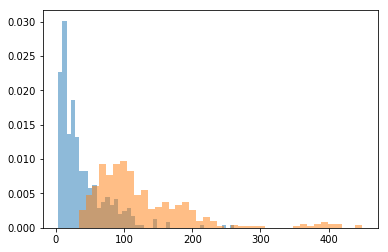

In [25]:
hist((spdata['A1']*gtrA)/1e-6/11.0,41,alpha = 0.5, density = True)
hist((iPSDsh*gtrG)*3/1e-6/25,41,alpha = 0.5, density = True)

In [26]:
770/236.4/13.0

0.25055316933489524

In [27]:
(spdata['A1']*gtrA).mean()/1e-6/11.0,(iPSDsh*gtrG).mean()/1e-6/236.4*770

(38.14754010503225, 3406.584727008143)

In [28]:
spdata['Rneck'] = spdata['Rneck']*300/250

In [29]:
td = 500
res = simulateSet(model,spdata,tG = td,ton = 50,
                  toffset = 70,t_stop = 500, 
                  EL = EL0,btsr = ones(9)==1,
                  VDCC = VDCCa,dendrec=False)

vavg,mes,vtracs,vtracsD,vtracsS,Ctracs,me2,me3,_ = res
with open(folderstore+"All_baseline_datasetv3_nosh.pickle","wb") as f:
    pickle.dump([vavg,mes,vtracs,vtracsD,vtracsS,
                 Ctracs,me2,me3,spdata],f) 
 

/export/home1/users/bssn/serna/environments/neuron/lib/python3.6/site-packages/ipykernel_launcher.py:161: RuntimeWarning: invalid value encountered in sqrt
/export/home1/users/bssn/serna/environments/neuron/lib/python3.6/site-packages/ipykernel_launcher.py:162: RuntimeWarning: invalid value encountered in sqrt


In [30]:
print('<uEPSP> = %.2f' % (mes[:,3].mean()))


<uEPSP> = 0.47


In [31]:
td = 500
res = simulateSet(model,spdata,tG = td,ton = 50,
                  toffset = 70,t_stop = 500, 
                  EL = EL0,btsr = ones(9)==1,
                  VDCC = VDCCa,dendrec=False)

vavg,mes,vtracs,vtracsD,vtracsS,Ctracs,me2,me3,_ = res

/export/home1/users/bssn/serna/environments/neuron/lib/python3.6/site-packages/ipykernel_launcher.py:161: RuntimeWarning: invalid value encountered in sqrt
/export/home1/users/bssn/serna/environments/neuron/lib/python3.6/site-packages/ipykernel_launcher.py:162: RuntimeWarning: invalid value encountered in sqrt


In [32]:
pp0 = 0.2
pp1 = 0.8
vtt = clip(vtracs-EL0,0,100)
times0 = get_FWHMtimes(vtt, v0 =0, dt = lb.h.dt)
t9010r = get_p0p1times(vtt,p0=pp0,p1= pp1, dt = lb.h.dt)
t90100 = get_postp0p1times(vtt,p0=pp0,p1= pp1, dt = lb.h.dt)

vtt = clip(vtracsS-EL0,0,100)
times0S = get_FWHMtimes(vtt, v0 =0, dt = lb.h.dt)
t9010rS = get_p0p1times(vtt,p0=pp0,p1= pp1, dt = lb.h.dt)
t90100S = get_postp0p1times(vtt,p0=pp0,p1= pp1, dt = lb.h.dt)

vtt = clip(vtracsD-EL0,0,100)
times0D = get_FWHMtimes(vtt, v0 =0, dt = lb.h.dt)
t9010rD = get_p0p1times(vtt,p0=pp0,p1= pp1, dt = lb.h.dt)
t90100D = get_postp0p1times(vtt,p0=pp0,p1= pp1, dt = lb.h.dt)

vtt = clip(Ctracs,0,100)
times0C = get_FWHMtimes(vtt, v0 =0, dt = lb.h.dt)
t9010rC = get_p0p1times(vtt,p0=pp0,p1= pp1, dt = lb.h.dt)
t90100C = get_postp0p1times(vtt,p0=pp0,p1= pp1, dt = lb.h.dt)
with open(folderstore+"All_baseline_datasetv3_times_nosh.pickle","wb") as f:
    pickle.dump([t90100, t90100S, t90100D, t90100C,
                t9010r, t9010rS, t9010rD, t9010rC],f) 

In [33]:
from bootstrap_unshr import  ShInhwpos,btShInhwpos

In [34]:
iPSDsh, posish = ShInhwpos(noise=0.0)


In [35]:
nishPSD = iPSDsh.shape[0]
spdatash = {}
for key in spdata.keys():
    spdatash[key] = array(spdata[key])[:nishPSD]
spdatash['A1'] = spdatash['A1']
spdatash['A2'] = spdatash['A2']*0+spdata['A2'].mean()
spdatash['Dss'] = posish

In [36]:
Erev0 = GABA.e
GABA.e = 0.0
GABA2.e = 0.0

gtrA = 0.0
gtrN = 0.0
gtrG = exppar.gtrG

res = simulateSet(model,spdatash,tG = 0,ton = 50,toffset = 70,
                  t_stop = 500, EL = EL0,btsr = ones(9)==1,
                  VDCC = VDCCa,dendrec=False,
                  inhOutside = True,iPSDsh=iPSDsh)

vavg,messh,vtracs,vtracsD,vtracsS,Ctracs,me2,me3,_ = res


res = simulateSet(model,spdata,tG = 0,ton = 50,toffset = 70,
                  t_stop = 500, EL = EL0,btsr = ones(9)==1,
                  VDCC = VDCCa,dendrec=False,
                  inhOutside = False)

vavg,mesDiS,vtracs,vtracsD,vtracsS,Ctracs,me2,me3,_ = res
gtrA = exppar.gtrA
gtrN = exppar.gtrN
gtrG = exppar.gtrG
GABA.e = Erev0
GABA2.e = Erev0

/export/home1/users/bssn/serna/environments/neuron/lib/python3.6/site-packages/ipykernel_launcher.py:161: RuntimeWarning: invalid value encountered in sqrt
/export/home1/users/bssn/serna/environments/neuron/lib/python3.6/site-packages/ipykernel_launcher.py:162: RuntimeWarning: invalid value encountered in sqrt


In [37]:
with open(folderstore+"All_baseline_depinhv3_nosh.pickle","wb") as f:
    pickle.dump([messh,iPSDsh,posish,mesDiS,spdata],f) 
 

In [38]:
sel = np.arange(len(spdata['A2']))[spdata['A2']>0]
print(sel)

[ 11  12  22  35  38  44  62  67  70  80  81  84  98 102 115 126 135 157
 163 184 185 208 209 214 222 225 236 248 253 264 296 299 321 360 362 366
 379]


In [39]:
import pandas as pd

In [40]:
pd_spdata = pd.DataFrame(spdata)

In [41]:
dis =  pd_spdata[pd_spdata['A2']>0]

In [42]:
#dis['Rneck'] = dis['Rneck']*300/250
#hist(dis['Rneck'])

In [43]:
 
def getint(x):
    xc = x*1.0
    xc.sort()
    sh = xc.shape[0]
    xmed = xc[sh//2]
    s0= int(sh*(1-.6827)/2)
    s1 = sh-s0
    x0 = xc[s0]
    x1 = xc[s1]
    s0b= int(sh*(1-.95)/2)
    s1b = sh-s0b
    try:
        x0b = xc[s0b]
        x1b = xc[s1b]
    except:
        x0b, x1b = xc[0], xc[-1]
    return((xmed,x0,x1,x0b,x1b))
    

In [44]:
#spdata['Rneck'] = Rneck0#*2
tdels = [-49,-30,-20,-15,-10,-7.5,-5,-3.5,-2,-1,-0.5,0,0.5,1.0,2.0,2.75,3.5,5.0,7.5,10.0,15.0,20.,30.,50]
dtime = zeros((len(tdels),20))
dtime2 = zeros((len(tdels),20))
data = zeros((len(tdels),20))
data2 = zeros((len(tdels),20))
datam = zeros((len(tdels),8))
dendsizeL = max(max(dis['Dss'])+5,150)

times_biexp = False
pp0 = 0.2
pp1 = 0.8

EL0 = -70
vavg0,mes0,vtracs0,vtracsD0,vtracsS0,Ctracs0,me20,me30, trec = simulateSet(model,dis,tG = 100,ton = 50,toffset = 100,t_stop = 500, EL = EL0,btsr = ones(9)==1,VDCC = VDCCa)

vtt = clip(vtracs0-EL0,0,100)
times0 = get_FWHMtimes(vtt, v0 =0, dt = lb.h.dt)
t90100 = get_postp0p1times(vtt,p0=pp0,p1= pp1, dt = lb.h.dt)

vtt = clip(vtracsS0-EL0,0,100)
times0S = get_FWHMtimes(vtt, v0 =0, dt = lb.h.dt)
t90100S = get_postp0p1times(vtt,p0=pp0,p1= pp1, dt = lb.h.dt)

vtt = clip(vtracsD0-EL0,0,100)
times0D = get_FWHMtimes(vtt, v0 =0, dt = lb.h.dt)
t90100D = get_postp0p1times(vtt,p0=pp0,p1= pp1, dt = lb.h.dt)

vtt = clip(Ctracs0,0,100)
times0C = get_FWHMtimes(vtt, v0 =0, dt = lb.h.dt)
t90100C = get_postp0p1times(vtt,p0=pp0,p1= pp1, dt = lb.h.dt)


for i,td in enumerate(tdels):
    vavg,mes,vtracs,vtracsD,vtracsS,Ctracs,me2,me3,_ = simulateSet(model,dis,tG = td,ton = 50,toffset = 100,t_stop = 500, EL = EL0,btsr = ones(9)==1,VDCC = VDCCa)
    
    # EPSP in spine head
    vtt = clip(vtracs-EL0,0,100)
    times = get_FWHMtimes(vtt, v0 =0, dt = lb.h.dt)
    t9010 = get_postp0p1times(vtt,p0=pp0,p1= pp1, dt = lb.h.dt)
    dtime[i,:5] = getint(times/times0)
    dtime2[i,:5] = getint(t9010/t90100)


    # EPSP In the soma
    vtt = clip(vtracsS-EL0,0,100)
    times = get_FWHMtimes(vtt, v0 =0, dt = lb.h.dt)
    t9010 = get_postp0p1times(vtt,p0=pp0,p1= pp1, dt = lb.h.dt)
    dtime[i,5:10] = getint(times/times0S)
    dtime2[i,5:10] = getint(t9010/t90100S)
    
    # EPSP In the soma
    vtt = clip(vtracsD-EL0,0,100)
    times = get_FWHMtimes(vtt, v0 =0, dt = lb.h.dt)
    t9010 = get_postp0p1times(vtt,p0=pp0,p1= pp1, dt = lb.h.dt)
    dtime[i,15:20] = getint(times/times0D)
    dtime2[i,15:20] = getint(t9010/t90100D)
    
    # For calcium in spine
    vtt = clip(Ctracs,0,100)
    times = get_FWHMtimes(vtt, v0 =0, dt = lb.h.dt)
    t9010 = get_postp0p1times(vtt,p0=pp0,p1= pp1, dt = lb.h.dt)
    dtime[i,10:15] = getint(times/times0C)
    dtime2[i,10:15] = getint(t9010/t90100C)
    
    # Statistics
    #data[i,:] = mes.mean(axis=0)
    #datt0 = mes[:,1:5]/mes0[:,1:5]
    #data2[i,:] = concatenate((datt0.mean(axis=0),datt0.std(axis=0)))
    for j in range(1,5):
        data[i,(5*(j-1)):(5*(j))] = getint(mes[:,j])
        data2[i,(5*(j-1)):(5*(j))] = getint(mes[:,j]/mes0[:,j])
        datam[i,(2*(j-1)):(2*(j))] = ((mes[:,j]/mes0[:,j]).mean(),(mes[:,j]/mes0[:,j]).std())

with open(folderstore+"inhibition_v3_nosh.pickle","wb") as f:
    pickle.dump([tdels,data2,data,dtime,dtime2,datam],f)

/export/home1/users/bssn/serna/environments/neuron/lib/python3.6/site-packages/ipykernel_launcher.py:161: RuntimeWarning: invalid value encountered in sqrt
/export/home1/users/bssn/serna/environments/neuron/lib/python3.6/site-packages/ipykernel_launcher.py:162: RuntimeWarning: invalid value encountered in sqrt


In [45]:

vtt = clip(vtracs0-EL0,0,100)
times0 = get_FWHMtimes(vtt, v0 =0, dt = lb.h.dt)
print(times0.shape)

(37,)


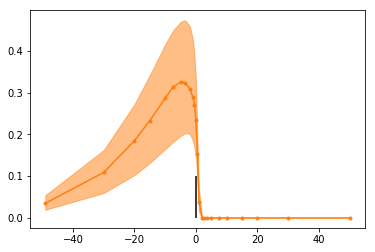

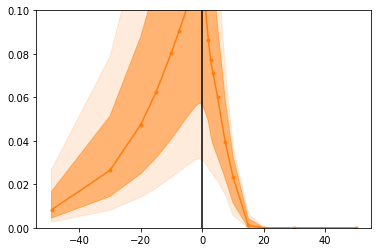

In [46]:
if plotose:
    inhtimDis = data2

    sh = len(tdels)
    vm,sl,sv = 1-inhtimDis[:sh,1*5],1-inhtimDis[:sh,1*5+1],1-inhtimDis[:sh,1*5+2]
    plot(tdels,vm,'C1.-',label='Axo-sp\n inhibition')
    fill_between(tdels,sl,sv,alpha=0.5,color='C1')
    vlines(0,0,0.1)
    figure()
    vm,sl,sv = 1-inhtimDis[:sh,3*5],1-inhtimDis[:sh,3*5+1],1-inhtimDis[:sh,3*5+2]
    sl2,sv2 = 1-inhtimDis[:sh,3*5+3],1-inhtimDis[:sh,3*5+4]

    plot(tdels,vm,'C1.-',label='Axo-sp\n inhibition')
    fill_between(tdels,sl,sv,alpha=0.5,color='C1')
    fill_between(tdels,sl2,sv2,alpha=0.15,color='C1')

    vlines(0,0,0.1)
    ylim(0,0.1)

In [47]:
(dis['A2']*gtrG).mean()/1e-3,(iPSDsh*gtrG).mean()/1e-3, ((iPSDsh*gtrG)/1e-3/(20.0*1e-3)).mean()

(0.5275113919867135, 0.9999999999999998, 50.0)

33.33333333333333

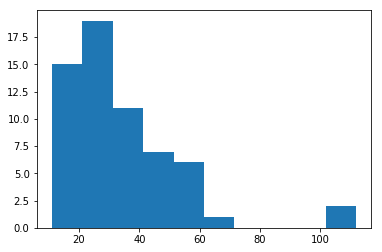

In [48]:
hist((iPSDsh*gtrG)/1e-3/(30.0*1e-3))
((iPSDsh*gtrG)/1e-3/(30.0*1e-3)).mean()

0.41962294115535465

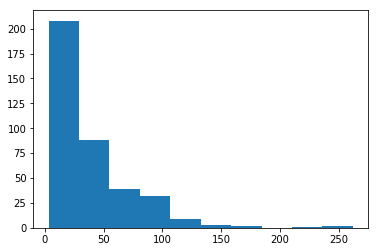

In [49]:
hist((spdata['A1']*gtrA)/1e-3/(11.0*1e-3))
((spdata['A1']*gtrA)/1e-3).mean()

In [50]:
sl2,sv2

(array([2.67512052e-02, 7.86143866e-02, 1.34394270e-01, 1.71761052e-01,
        2.14493042e-01, 2.36886058e-01, 2.58763129e-01, 2.70923820e-01,
        2.81483073e-01, 2.86414209e-01, 2.86997722e-01, 2.83911614e-01,
        2.73723956e-01, 2.58717485e-01, 2.22539158e-01, 1.93959429e-01,
        1.66075526e-01, 1.21263672e-01, 7.35692200e-02, 3.76507087e-02,
        6.69234461e-03, 2.22044605e-16, 2.22044605e-16, 2.22044605e-16]),
 array([0.00260806, 0.00806143, 0.01404618, 0.01820807, 0.02315159,
        0.02583072, 0.02851043, 0.03001768, 0.03128278, 0.03176883,
        0.03175765, 0.03141247, 0.03063479, 0.02964968, 0.02754571,
        0.02599732, 0.02449642, 0.02159743, 0.01533507, 0.00576483,
        0.        , 0.        , 0.        , 0.        ]))

gtrG, gtrA = x4 (x8), x3

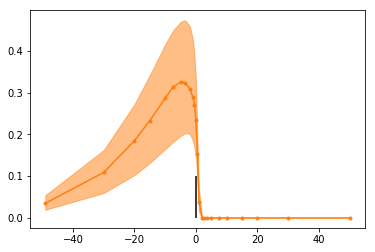

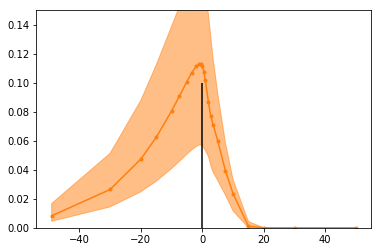

In [51]:
if plotose:
    inhtimDis = data2

    sh = len(tdels)
    vm,sl,sv = 1-inhtimDis[:sh,1*5],1-inhtimDis[:sh,1*5+1],1-inhtimDis[:sh,1*5+2]
    plot(tdels,vm,'C1.-',label='Axo-sp\n inhibition')
    fill_between(tdels,sl,sv,alpha=0.5,color='C1')
    vlines(0,0,0.1)
    figure()
    vm,sl,sv = 1-inhtimDis[:sh,3*5],1-inhtimDis[:sh,3*5+1],1-inhtimDis[:sh,3*5+2]
    plot(tdels,vm,'C1.-',label='Axo-sp\n inhibition')
    fill_between(tdels,sl,sv,alpha=0.5,color='C1')
    vlines(0,0,0.1)
    ylim(0,0.15)

In [52]:
td = 10
vavg,mes,vtracs,vtracsD,vtracsS,Ctracs,me2,me3,_ = simulateSet(model,dis,tG = td,ton = 50,toffset = 70,t_stop = 500, EL = EL0,btsr = ones(9)==1,VDCC = VDCCa)
with open(folderstore+"dis_glu_ga10v3_nosh.pickle","wb") as f:
    pickle.dump([vavg,mes,vtracs,vtracsD,vtracsS,Ctracs],f) 
    
td = -10
vavg,mes,vtracs,vtracsD,vtracsS,Ctracs,me2,me3,_ = simulateSet(model,dis,tG = td,ton = 50,toffset = 70,t_stop = 500, EL = EL0,btsr = ones(9)==1,VDCC = VDCCa)
with open(folderstore+"dis_ga_glu10v3_nosh.pickle","wb") as f:
    pickle.dump([vavg,mes,vtracs,vtracsD,vtracsS,Ctracs],f) 
      
td = 5
vavg,mes,vtracs,vtracsD,vtracsS,Ctracs,me2,me3,_ = simulateSet(model,dis,tG = td,ton = 50,toffset = 70,t_stop = 500, EL = EL0,btsr = ones(9)==1,VDCC = VDCCa)
with open(folderstore+"dis_glu_ga05v3_nosh.pickle","wb") as f:
    pickle.dump([vavg,mes,vtracs,vtracsD,vtracsS,Ctracs],f) 
    
td = -5
vavg,mes,vtracs,vtracsD,vtracsS,Ctracs,me2,me3,_ = simulateSet(model,dis,tG = td,ton = 50,toffset = 70,t_stop = 500, EL = EL0,btsr = ones(9)==1,VDCC = VDCCa)
with open(folderstore+"dis_ga_glu05v3_nosh.pickle","wb") as f:
    pickle.dump([vavg,mes,vtracs,vtracsD,vtracsS,Ctracs],f) 
    
    
td = 500
vavg,mes,vtracs,vtracsD,vtracsS,Ctracs,me2,me3,_ = simulateSet(model,dis,tG = td,ton = 50,toffset = 70,t_stop = 500, EL = EL0,btsr = ones(9)==1,VDCC = VDCCa)
with open(folderstore+"dis_baselinev3_nosh.pickle","wb") as f:
    pickle.dump([vavg,mes,vtracs,vtracsD,vtracsS,Ctracs],f) 
    
td = 500

vavg0,mes0,vtracs0,vtracsD0,vtracsS0,Ctracs0,me20,me30,_ = simulateSet(model,dis,tG = td,ton = 50,toffset = 70,t_stop = 500, EL = EL0,btsr = ones(9)==1,VDCC = VDCCa,dendrec=False)
   
td = -2
vavg,mes,vtracs,vtracsD,vtracsS,Ctracs,me2,me3,_ = simulateSet(model,dis,tG = td,ton = 50,toffset = 70,t_stop = 500, EL = EL0,btsr = ones(9)==1,VDCC = VDCCa)
with open(folderstore+"dis_ga_glu02v3_nosh.pickle","wb") as f:
    pickle.dump([dis,mes,mes0],f) 

td = 2
vavg,mes,vtracs,vtracsD,vtracsS,Ctracs,me2,me3,_ = simulateSet(model,dis,tG = td,ton = 50,toffset = 70,t_stop = 500, EL = EL0,btsr = ones(9)==1,VDCC = VDCCa)

vtt = clip(vtracs0-EL0,0,100)
if times_biexp:
    times0 = get_atimes(vtt,ton=3000)
else:
    times0, tt, trise = get_atimes(vtt,ton=3000)
    times0 = get_FWHMtimes(vtt, v0 =0, dt = lb.h.dt)

vtt = clip(vtracs-EL0,0,100)
if times_biexp:
    times = get_atimes(vtt,ton=3000)
else:
    times, tt, trise = get_atimes(vtt,ton=3000)
    times = get_FWHMtimes(vtt, v0 =0, dt = lb.h.dt)

with open(folderstore+"dis_glu_ga02v3_nosh.pickle","wb") as f:
    pickle.dump([dis,mes,mes0,times,times0],f) 
    
    

/export/home1/users/bssn/serna/environments/neuron/lib/python3.6/site-packages/ipykernel_launcher.py:161: RuntimeWarning: invalid value encountered in sqrt
/export/home1/users/bssn/serna/environments/neuron/lib/python3.6/site-packages/ipykernel_launcher.py:162: RuntimeWarning: invalid value encountered in sqrt
/export/home1/users/bssn/serna/HBP/SpineModel/PS_tools.py:6: RuntimeWarning: invalid value encountered in double_scalars
  numtt = (t2/t1)**(te/t1)-(t2/t1)**(te/t2)


In [53]:
#spdata['Rneck'] = Rneck0#*2
tdels = [-49,-30,-20,-15,-10,-7.5,-5,-3.5,-2,-1,-0.5,0,0.5,1.0,2.0,2.75,3.5,5.0,7.5,10.0,15.0,20.,30.,50]
dtime = zeros((len(tdels),20))
dtime2 = zeros((len(tdels),20))
data = zeros((len(tdels),20))
data2 = zeros((len(tdels),20))
datam = zeros((len(tdels),8))
sps = btset_cd(cd='Sp',size=nsp)
sps['A2'] = 0.0*sps['A1']
iPSDsh, posish = btShInhwpos(nsp)

dendsizeL = max(max(sps['Dss'])+5,150)
pp0 = 0.2
pp1 = 0.8
times_biexp = False

EL0 = -70
res = simulateSet(model,sps,tG = 100,ton = 50,
                  toffset = 100,t_stop = 500, 
                  EL = EL0,btsr = ones(9)==1,VDCC = VDCCa,inhOutside= True, iPSDsh = iPSDsh)
vavg0,mes0,vtracs0,vtracsD0,vtracsS0,Ctracs0,me20,me30, trec = res

vtt = clip(vtracs0-EL0,0,100)
times0 = get_FWHMtimes(vtt, v0 =0, dt = lb.h.dt)
t90100 = get_postp0p1times(vtt,p0=pp0,p1= pp1, dt = lb.h.dt)

vtt = clip(vtracsS0-EL0,0,100)
times0S = get_FWHMtimes(vtt, v0 =0, dt = lb.h.dt)
t90100S = get_postp0p1times(vtt,p0=pp0,p1= pp1, dt = lb.h.dt)

vtt = clip(vtracsD0-EL0,0,100)
times0D = get_FWHMtimes(vtt, v0 =0, dt = lb.h.dt)
t90100D = get_postp0p1times(vtt,p0=pp0,p1= pp1, dt = lb.h.dt)

vtt = clip(Ctracs0,0,100)
times0C = get_FWHMtimes(vtt, v0 =0, dt = lb.h.dt)
t90100C = get_postp0p1times(vtt,p0=pp0,p1= pp1, dt = lb.h.dt)



for i,td in enumerate(tdels):
    res = simulateSet(model,sps,tG = td,ton = 50,
                      toffset = 100,t_stop = 500, 
                      EL = EL0,btsr = ones(9)==1,
                      VDCC = VDCCa,inhOutside= True, iPSDsh = iPSDsh)
    vavg,mes,vtracs,vtracsD,vtracsS,Ctracs,me2,me3,_  = res
    # EPSP in spine head
    vtt = clip(vtracs-EL0,0,100)
    times = get_FWHMtimes(vtt, v0 =0, dt = lb.h.dt)
    t9010 = get_postp0p1times(vtt,p0=pp0,p1= pp1, dt = lb.h.dt)
    dtime[i,:5] = getint(times/times0)
    dtime2[i,:5] = getint(t9010/t90100)


    # EPSP In the soma
    vtt = clip(vtracsS-EL0,0,100)
    times = get_FWHMtimes(vtt, v0 =0, dt = lb.h.dt)
    t9010 = get_postp0p1times(vtt,p0=pp0,p1= pp1, dt = lb.h.dt)
    dtime[i,5:10] = getint(times/times0S)
    dtime2[i,5:10] = getint(t9010/t90100S)
    
    # EPSP In the soma
    vtt = clip(vtracsD-EL0,0,100)
    times = get_FWHMtimes(vtt, v0 =0, dt = lb.h.dt)
    t9010 = get_postp0p1times(vtt,p0=pp0,p1= pp1, dt = lb.h.dt)
    dtime[i,15:20] = getint(times/times0D)
    dtime2[i,15:20] = getint(t9010/t90100D)
    
    # For calcium in spine
    vtt = clip(Ctracs,0,100)
    times = get_FWHMtimes(vtt, v0 =0, dt = lb.h.dt)
    t9010 = get_postp0p1times(vtt,p0=pp0,p1= pp1, dt = lb.h.dt)
    dtime[i,10:15] = getint(times/times0C)
    dtime2[i,10:15] = getint(t9010/t90100C)
    
    # Statistics
    #data[i,:] = mes.mean(axis=0)
    #datt0 = mes[:,1:5]/mes0[:,1:5]
    #data2[i,:] = concatenate((datt0.mean(axis=0),datt0.std(axis=0)))
    for j in range(1,5):
        data[i,(5*(j-1)):(5*(j))] = getint(mes[:,j])
        data2[i,(5*(j-1)):(5*(j))] = getint(mes[:,j]/mes0[:,j])
        datam[i,(2*(j-1)):(2*(j))] = ((mes[:,j]/mes0[:,j]).mean(),(mes[:,j]/mes0[:,j]).std())

with open(folderstore+"inhibition_v3_outPSD_nosh.pickle","wb") as f:
    pickle.dump([tdels,data2,data,dtime,dtime2,datam],f)

/export/home1/users/bssn/serna/environments/neuron/lib/python3.6/site-packages/ipykernel_launcher.py:161: RuntimeWarning: invalid value encountered in sqrt
/export/home1/users/bssn/serna/environments/neuron/lib/python3.6/site-packages/ipykernel_launcher.py:162: RuntimeWarning: invalid value encountered in sqrt
